In [1]:
sys.path.append('../') #server per fare l'import di file in un'altra directory sullo stesso "livello"
import matplotlib.pyplot as plt
from src.NeuralNetwork import NeuralNetwork, Layer
from src.function import IdentityFunction, SigmoideFunction
from src.load_ds import load_monks_1_train
import numpy as np

import torch
import torch.nn as nn

In [2]:
# Loading data
target_inputs, target_outputs = load_monks_1_train()



In [3]:
# Monk has an input of 17 features (after one-hot encoding) and 1 output (0 or 1)
# Generating model
input_layer = Layer(num_neurons = 5, num_inputs = 17, activation_function = SigmoideFunction())
hidden_layer = Layer(num_neurons = 2, num_inputs = 5, activation_function = SigmoideFunction())
output_layer = Layer(num_neurons = 1, num_inputs = 2, activation_function = SigmoideFunction())

neuralNetwork = NeuralNetwork([input_layer, hidden_layer, output_layer])


In [4]:
# Training

error_history = neuralNetwork.train(target_inputs, target_outputs, epochs = 100, learning_rate = 0.01, regularization_term=0.1, momentum_term=0.5)

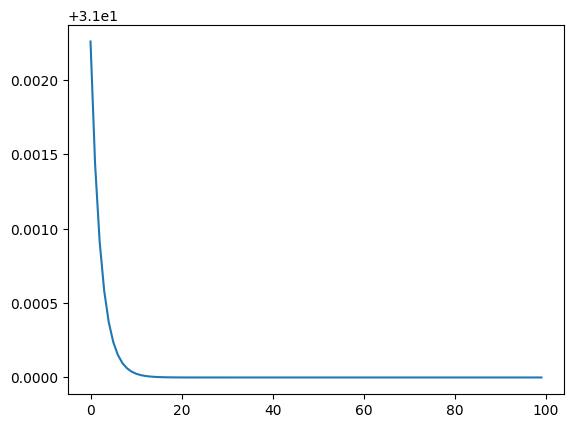

In [5]:
plt.plot(error_history)

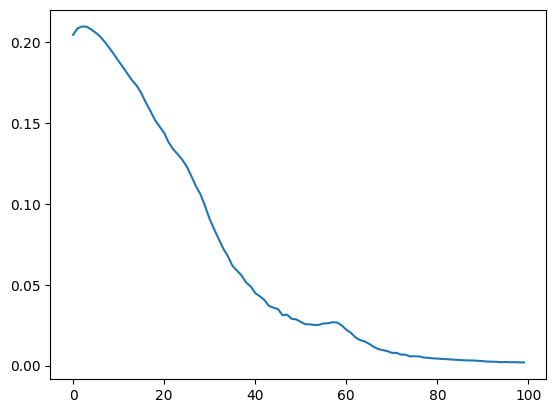

In [6]:
# Torch model
import torch

# to tensors (float)
target_inputs = torch.tensor(target_inputs, dtype=torch.float)
target_outputs = torch.tensor(target_outputs, dtype=torch.float)
train_errors = []

class SimpleModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = torch.nn.Linear(17, 5)
        self.linear2 = torch.nn.Linear(5, 2)
        self.linear3 = torch.nn.Linear(2, 1)
        
    def forward(self, x):
        x = self.linear1(x)
        x = torch.relu(x)  # apply ReLU activation function
        x = self.linear2(x)
        x = torch.relu(x)  # apply ReLU activation function
        x = self.linear3(x)
        x = torch.sigmoid(x)

        return x

model = SimpleModel()
learning_rate = 0.01
# define the loss function
loss_fn = torch.nn.MSELoss()  # mean squared error loss

# define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # stochastic gradient descent with a learning rate of 0.1

#Set bias to 0
model.linear1.bias = torch.nn.Parameter(torch.zeros(5))
model.linear2.bias = torch.nn.Parameter(torch.zeros(2))
model.linear3.bias = torch.nn.Parameter(torch.zeros(1))

# loop over the training data
for epoch in range(100):
    
    for x, y_true in zip(target_inputs, target_outputs):
        # pass the input through the model to get the predictions
        y_pred = model(x)

        # compute the loss
        loss = loss_fn(y_pred, y_true)

        # zero the gradients before backpropagating
        model.zero_grad()

        # backpropagate the gradients
        loss.backward()

        # update the model's parameters
        #model.step()
        with torch.no_grad():
            for param in model.parameters():
                param -= learning_rate * param.grad

    
        
    # store the training and validation errors
    train_errors.append(loss.item())
    
# error plot

plt.plot(train_errors)